In [49]:
%matplotlib inline

In [50]:
import numpy as np
import scipy
from scipy.misc import logsumexp
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
%run preprocess.ipynb

EXP3_N_PARTICIPANT = 112
EXP3_N_UNFINISHED = 6
EXP3_N_CAUGHT = 5
EXP3_N_REMAIN = 101
EXP3_N_RT_CLIP = 35
EXP3_THRESHOLD_RT_CLIP = 12.155521660073683
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


preprocess.ipynb:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  "outputs": [],


In [78]:
def logp_bernoulli(x, p):
    return np.log((x * p) + ((1 - x) * (1 - p)))

In [79]:
def change_model(df, p_cue, p_trick, p_sim):
    correct = df.correct.as_matrix()
    kind = df.kind.as_matrix()
    cue = df.cuex.as_matrix()
    good_cue = df.good_cue.as_matrix()
    trials = df.trialx.as_matrix()
    
    N = len(correct)
    lh_cue = np.empty((N, N))
    for switchpoint in range(N):
        for j in range(N):
            using_cue = cue[j] and (j > switchpoint)
            if using_cue:
                if good_cue[j]:
                    p = p_cue
                else:
                    p = p_trick
            else:
                p = p_sim[kind[j]]

            lh_cue[switchpoint, j] = logp_bernoulli(correct[j], p)

    lh_cue = lh_cue.sum(axis=1)    
    best = lh_cue.argmax()
    n_best = (lh_cue == lh_cue[best]).sum()
    if n_best > 1:
        best = np.arange(len(lh_cue))[lh_cue == lh_cue[best]][-1]

    return lh_cue[best], trials[best] - trials.min()

In [80]:
def nochange_model(df, p_sim):
    correct = df.correct.as_matrix()
    kind = df.kind.as_matrix()
    
    N = len(correct)
    lh_none = np.empty(N)
    for j in range(N):
        lh_none[j] = logp_bernoulli(correct[j], p_sim[kind[j]])

    lh_none = lh_none.sum()
    return lh_none

In [81]:
def BIC(N, k, lh):
    return np.log(N) * k - 2 * lh

In [82]:
def calc_p_sim(df):
    a = (df == 1).sum()
    b = (df == 0).sum()
    return (a + 0.5) / (a + b + 1)

In [83]:
def max_lh_switch(pidx, df, num_comparisons, p_cue=0.95):
    p_trick = 1 - p_cue
    p_sim = df.query("cuex == False").groupby("kind")["correct"].apply(calc_p_sim).to_dict()
    N = len(df)

    lh_cue, best = change_model(df, p_cue, p_trick, p_sim)
    lh_none = nochange_model(df, p_sim)
    llhr = lh_cue - lh_none
    D = 2 * llhr
    #p = min(1, (1 - scipy.stats.chi2.cdf(D, 1)) * num_comparisons)
    p = 1 - scipy.stats.chi2.cdf(D, 1)
    
    ret = pd.Series({
        "switch_idx": best,
        "llh_cue": lh_cue,
        "llh_none": lh_none, 
        "bic_cue": BIC(N, 1, lh_cue),
        "bic_none": BIC(N, 0, lh_none),
        "llhr": llhr,
        "D": D,
        "pr_chisq": p,
        "signif": pval(p),
        "df": 1,
        "feedback_cond": df["feedback_cond"].unique()[0],
        "p_cue": p_cue,
        "p_trick": p_trick,
    }, name=pidx)
    ret.index.name = "pidx"
    
    for kind in p_sim:
        ret["p_sim_{}".format(kind)] = p_sim[kind]
    
    return ret

In [84]:
def fit_models(df):
    pids = df.pidx.unique()
    switch = pd.DataFrame([max_lh_switch(p, df.ix[p], len(pids)) for p in pids])
    switch['cue_better'] = switch.bic_none > switch.bic_cue
    switch['bic_diff'] = switch.bic_none - switch.bic_cue
    return switch

In [85]:
threshold = 0.001
writevar('SWITCH_THRESHOLD', threshold)
switch = fit_models(ndf)

EXP3_SWITCH_THRESHOLD = 0.001


/usr/local/lib/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


In [86]:
pdf['switched'] = switch.pr_chisq < threshold
tbl = pdf.groupby('feedback').switched.value_counts().unstack()
tbl = tbl.fillna(0).astype(int)

In [87]:
sfb = tbl[True][True]
snofb = tbl[True][False]
writevar('SWITCH_FB', sfb)
writevar('SWITCH_NOFB', snofb)
success = tbl[1]
count = tbl.sum(axis=1)

EXP3_SWITCH_FB = 2
EXP3_SWITCH_NOFB = 0


In [62]:
%%R -i success -i count -i threshold -o p1 -o p2 -o p3
p1 = prop.test(success[1], count[1], p=threshold)
p2 = prop.test(success[2], count[2], p=threshold)
p3 = prop.test(success, count, p=c(threshold, threshold))

In [63]:
comps = {
    'nofb_null': {k: ri2py(v) for k, v in p1.items()},
    'fb_null': {k: ri2py(v) for k, v in p2.items()},
    'fb_nofb': {k: ri2py(v) for k, v in p3.items()},
}
extract = ['estimate', 'statistic', 'p.value', 'parameter']
tbl = pd.DataFrame(
    {e: [vals[e] for vals in comps.values()] for e in extract},
    index = comps.keys()
)
tex_chi2 = r"$\chi^2({parameter:.0f})={statistic:.0f},\ {signif}$"

tbl = tbl.applymap(lambda x: x[0] if len(x) == 1 else x[1] - x[0])
tbl = tbl.rename(columns=reformat_name)
tbl['signif'] = tbl[reformat_name('p_value')].apply(pval)
save_analysis(tbl, 'SWITCH_CHI_{idx}', tex_chi2)
savevars()


EXP3_SWITCH_CHI_FB_NOFB = $\chi^2(2)=47,\ p < 0.001$


<IPython.core.display.Latex object>

EXP3_SWITCH_CHI_NOFB_NULL = $\chi^2(1)=0,\ p = 1.00$


<IPython.core.display.Latex object>

EXP3_SWITCH_CHI_FB_NULL = $\chi^2(1)=43,\ p < 0.001$


<IPython.core.display.Latex object>

In [64]:
pdf['passed_quiz'] = final_qdf.set_index('pidx', drop=False).perfect

tbl = pdf.groupby(['feedback', 'passed_quiz']).switched.value_counts().unstack().T
tbl = tbl.rename(int, int).fillna(0).astype(int)
tbl

feedback      0       1   
passed_quiz   0   1   0  1
switched                  
0            41  11  38  9
1             0   0   0  2

In [65]:
# cue quiz table
for f in (0, 1):
    row = []
    for m in (0, 1):
        for q in (0, 1):
            n = tbl[f][q][m]
            row.append(n)
    fb = ['NOFB', 'FB'][f]
    writevar('TABLE_'+fb, ' & ' + ' & '.join(map(str, row)))

counts = pdf.feedback.value_counts()
writevar('N_NO_FEEDBACK', counts[False])
writevar('N_FEEDBACK', counts[True])
savevars()

EXP3_TABLE_NOFB =  & 41 & 11 & 0 & 0
EXP3_TABLE_FB =  & 38 & 9 & 0 & 2
EXP3_N_NO_FEEDBACK = 53
EXP3_N_FEEDBACK = 49


In [23]:
best = np.asarray(switch.sort_values(by='bic_diff', ascending=False).index)
good = switch.query('cue_better')

In [24]:
nofb = switch.query('pr_chisq < {} and ~feedback_cond'.format(threshold)).sort_values(by='bic_diff', ascending=False)
no_fb_learners = list(nofb.index)

[56, 41, 101, 65, 31, 59, 58, 25]

In [25]:
fb = switch.query('pr_chisq < {} and feedback_cond'.format(threshold)).sort_values(by='bic_diff', ascending=False)
fb_learners = list(fb.index)

/usr/local/lib/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


../paper/figs/1/learners.pdf


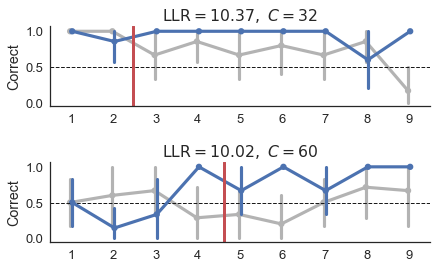

In [26]:
@plot()
def plot_learners(ps=no_fb_learners[:2]):
    if not isinstance(ps, list):
        ps = [ps]
    if not ps:
        print("Can't plot learners when there aren't any learners :(")
        return
    fig, axes = plt.subplots(len(ps), 1, squeeze=False)
    for p, ax in zip(ps, axes.ravel()):
        plt.sca(ax)
        d = ndf[ndf.pidx == p].copy()
        sns.pointplot('block', 'correct', hue='cue', data=d, 
                      **PK, aspect=3, size=4, ax=ax)
        ax.set_title(r'$\mathrm{{LLR}}={llhr:.2f},\ C={switch_idx:.0f}$'.format(**switch.ix[p]))
        
        blocklen = bdf[bdf.pidx == 48].groupby("block").apply(len)
        mintrial = blocklen[1:2].sum()
        maxtrial = blocklen[1:-1].sum() + 1
        switch_idx = switch.ix[p].switch_idx
        x = 8 * (switch_idx - mintrial) / (maxtrial - mintrial)
        ax.axvline(x, c='r', ls='-', lw=3)

        ax.hlines(0.5, -0.5, 9.5, linestyle='--', linewidth=1, color='k')
        ax.set_yticks([0, 0.5, 1])
        ax.legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('Correct')
        # ax.set_xticklabels(np.cumsum(blocklen[1:]))

    fig.set_size_inches(6, 4)
    plt.tight_layout()
    plt.subplots_adjust(left=0.11, right=0.99)
    sns.despine()